In [1]:
from fastai.basics import *
from fastai.gen_doc.nbdoc import *

In [2]:
import fastai
from fastai.version import __version__
print(__version__)

1.0.61


## Text

Next application is text, so let's start by importing everything we'll need.

In [3]:
from fastai.text import *

### Language modelling

First we'll fine-tune a pretrained language model on our subset of imdb.

In [4]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [5]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_by_rand_pct()
                   .label_for_lm()  # Language model does not need labels
                   .databunch())
data_lm.save()

`data.show_batch()` will work here as well. For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).

In [6]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj xxunk - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,count xxmaj igor xxmaj xxunk was horribly burned and killed in a lab accident . \n \n xxmaj then a woman xxmaj xxunk ( xxmaj xxunk xxmaj xxunk ) that xxmaj igor hired before his death to xxunk him in his xxunk shows up . xxmaj yanos xxunk to hire her in place of his brother and together they seek the xxunk for the xxunk of dead xxunk .
2,"xxmaj barnes is oh so hot for her , but she cares only about one thing : getting rid of xxmaj celeste so that she might shine more xxunk on the set . xxmaj to this end she gets xxmaj barnes to do all sorts of things to wreck xxmaj celeste 's career , but through xxunk and / or a xxunk logic , all his attempts go awry ,"
3,"xxmaj xxunk it like xxmaj xxunk "" i believe it is a true gem . xxbos xxmaj the fact that most of the budget for this presumably went on the heavy - duty cast list should n't have mattered if it had been staged with flair and imagination and some sympathy for the original 's satirical intent . xxmaj instead we get xxunk bad song and dance sequences featuring xxunk"
4,"xxmaj when he comes to hand out xxunk to xxmaj valjean and xxmaj cosette , he says the one line in the movie that set me screaming at the xxup tv set . "" xxmaj we are n't xxunk . "" i could hear xxmaj victor xxmaj hugo xxunk in his grave . xxup of xxup course xxup they xxup are xxup xxunk ! xxmaj they want to xxunk against"


In [7]:
# Special tokens
# xxbos: Begining of a sentence
# xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
# xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
# xxunk: token used instead of an uncommon word.
# xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
# xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

In [8]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

#### Numericalization
Finally it is easier for machine to deal with the numbers so replace the tokens with the location of the token in the vocab:

In [9]:
data_lm.train_ds[0][0].data[:10]

array([   2,    5, 4562,   24,    0,   24,  864,   52,    5, 3738])

The default vocab size is set to 60,000 words and min count for a word to be added to vocab is 2, to avoid getting the weight matrix huge.

Now let's define a language model learner. drop_mult - a hyper-parameter ,used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(4, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.384156,3.781654,0.290834,00:20
1,4.131581,3.731234,0.293136,00:20
2,3.916430,3.722423,0.294294,00:20
3,3.759709,3.716828,0.294238,00:21


Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

In [11]:
learn.show_results()

text,target,pred
xxbos i just watched xxmaj xxunk xxmaj fisher on xxup bravo . xxmaj what an awesome movie and incredible young,man . xxmaj this movie is a must see for anyone who is dealing with how to overcome childhood abuse,film . xxmaj it movie is a great see for all who is xxunk with the much watch the problems
scenes really need to take a xxunk and just be a nice part of the background . xxmaj this was,"just a tv - movie , though , so they had to add some xxmaj xxunk to the picture and","a a very show xxunk , and it and it were to be a xxunk xxunk xxmaj the movie ."
"as every low budget production does , it is a good start for xxmaj ms. xxmaj xxunk and her company",. \n \n xxmaj the story is not terribly new having been done in films like xxmaj the xxmaj,"is xxmaj xxmaj xxunk xxmaj is a a original , been written in the like xxmaj xxunk xxmaj xxunk xxmaj"
unhappy xxunk . xxmaj kyle xxunk xxmaj xxunk xxmaj mitch xxunk xxmaj hudson ) are xxunk friends with different looks,on life . xxmaj kyle is the xxunk son of an oil xxunk ; xxmaj mitch works for the xxmaj,and the . xxmaj the xxmaj a xxunk of of xxmaj old who who xxmaj xxunk xxmaj as the xxunk
it all looks cheap and never comes close to the standards of our xxmaj russian men and women of the,early 19th century . \n \n a good piece of entertainment to xxunk and make fun of . xxmaj,xxmaj 1970s century . xxmaj xxmaj xxmaj movie of xxmaj is be the xxunk a of the xxmaj it are


In [12]:
learn.predict('When I saw this movie the second time', 100)


"When I saw this movie the second time i was seen , you thought it . What is next ! It 's like , \n \n  This is one of the worst movies on earth , and it almost captures U.s. and nature , so it looks like a German movie . And it looks like a 3D game . The best thing is the realism ! It is same in that we live on the earth . Yes , not considering that it 's last for there . Not even . No more editing ."

In [13]:
learn.predict('As I was going up the stair I met a man who wasn\'t there.', 100)

'As I was going up the stair I met a man who wasn\'t there. He was a bunch of kinds , and the human journey looked like a broken Corpse Works , someone vulnerable the South . " Here is a girl named Elliot who is talking about this summer finding funny flicks . i read this movie and stumbles on the back of 10 TRICK . Besides , only i guess . But when i was first told about the formula scene he did not give a high note . That was it ... i was disappointing . Anyone played this film'

Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. Now look at the plot of learning rate against loss and determine the lowest point (around 1e-1 for the plot below) and go back by one magnitude and choose that as a learning rate (something around 1e-2).

### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [14]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Here show_batch shows the beginning of each review with its target.

In [15]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj xxunk ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj xxunk to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


And we can train a classifier that uses our previous encoder.

In [16]:
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('mini_train_encoder')
learn_cl.fit_one_cycle(6, slice(1e-3,1e-2))
learn_cl.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.599678,0.604478,0.715000,00:16
1,0.543389,0.583306,0.635000,00:17
2,0.512465,0.606270,0.690000,00:18
3,0.471151,0.542017,0.705000,00:17
4,0.453810,0.534058,0.705000,00:17
5,0.429361,0.532531,0.700000,00:18


**Momentum**  
There is one more argument(moms=(0.8,0.7))﹣momentums equals 0.8,0.7. Basically for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit.The right side above is the momentum plot. Every time our learning rate is small, our momentum is high. Why is that? Because as you are learning small learning rate, but you keep going in the same direction, you may as well go faster (higher momentum). But as you are learning high learning rate, but you keep going in the same direction, you may overshoot the target, so momentum should be slowed. This trick can help you train 10 times faster.

In [17]:
learn_cl.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.369112,0.676978,0.665000,00:16
1,0.385241,0.525412,0.720000,00:17


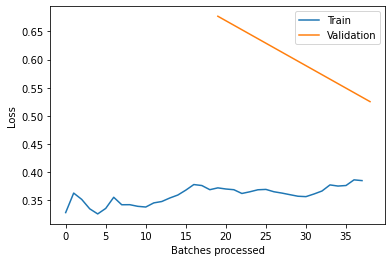

In [18]:
learn_cl.recorder.plot_losses()

In [19]:
learn_cl.show_results()

text,target,prediction
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive,positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj xxunk xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj xxunk "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,negative
"xxbos xxmaj bonanza had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj pernell xxmaj whitaker , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj blocker , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during 1964 to xxunk xxmaj adam when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,positive


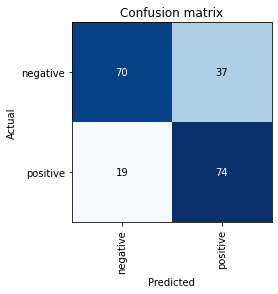

In [20]:
preds, y, losses = learn_cl.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_cl, preds, y, losses)
interp.plot_confusion_matrix()

### Excercise
Make sentiment predictions for 5 movie reviews from IMDB web site.

In [32]:
first_movie_review = learn.predict('This endlessly fascinating swirl ', 100)
first_movie_review

'This endlessly fascinating swirl  back up , Reference to Complicated Winston and the lack of enthusiasm in the disastrous years of his fellow de Niro and always in TV . He asked the apparently who had received all this more fully , having bothered his father in death , and after missing less than thirteen years . The genuine sadness left me feeling sorry for the filmmakers , who are interested in Pace obviously . At first his great taste in English days came when he was great and his my friend Adrian'

In [31]:
real_first_movie_review = print('This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight')

This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight


In [35]:
second_movie_quote= learn.predict('The greatest trick the Devil ever pulled', 14)
second_movie_quote

'The greatest trick the Devil ever pulled is from the background laws of the German Revolution when he died'

In [36]:
real_second_quote = print("The greatest trick the Devil ever pulled was convincing the world he didn't exist")

The greatest trick the Devil ever pulled was convincing the world he didn't exist


In [38]:
third_movie_review = learn.predict('Overall, the film is one of a kind,',35)
third_movie_review

"Overall, the film is one of a kind, but it is not a low - budget films , but other English films are n't . Unfortunately watching this movie 've , with a conflict with director Tom Hanks ,"

In [39]:
real_third_movie_review = print('Overall, the film is one of a kind, a masterpiece and a work of art so to speak. The superior musical score that accompanies the film heightens the suspense and adds to the mystery sequences.')

Overall, the film is one of a kind, a masterpiece and a work of art so to speak. The superior musical score that accompanies the film heightens the suspense and adds to the mystery sequences.


In [40]:
fourth_movie_review = learn.predict('Nolan masterfully weaves', 28)
fourth_movie_review

"Nolan masterfully weaves over this budget of his youth with those of Nolan 's FANFAN early 3D versions , his his greatest complaint for the seventies and whether"

In [41]:
real_fourth_review = print('Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.')

Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.


In [45]:
fifth_movie_review = learn.predict('Infused with',27)
fifth_movie_review

'Infused with the concept \' " formula snakes " \' , innocence in fear and violence towards the ordinary people is the one he uses perfectly him .'

In [44]:
real_fifth_movie_review = print('Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.')

Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.
